# Sparse Spiking Ensemble

- Ensemble = Sensory neurons + latent neurons
- Sensory neurons get spikes from sensory inputs
- Sensory inputs are sparse coded (~20% 1s, rest 0s)
- Each neuron also takes input from the whole ensemble (later to be restricted locally)

## New in this notebook
- Simplify firing model
- Fix accumulation of inputs

## Results
When showing Ax250,Bx250,Ax250,Bx250
- On first 250 impressions of A, one of the neurons N1 becomes aligned with the pattern A, while the other neuron N2 is forced to align with inverse of A
- Then B is shown N2 fires and becomes aligned with pattern B, while N1 now is aligned with (A U ~B)


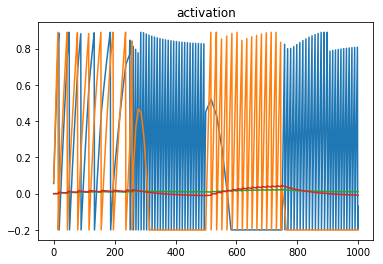

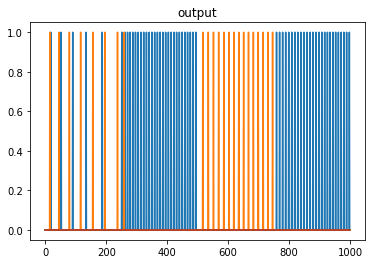

In [108]:
from collections import defaultdict
import torch
import matplotlib.pyplot as plt

SENSORY_MODALITY_1_WIDTH = 10
SENSORY_MODALITY_1_HEIGHT = 10
SENSORY_MODALITY_1_SIZE = SENSORY_MODALITY_1_WIDTH * SENSORY_MODALITY_1_HEIGHT

SENSORY_MODALITY_1_NEURONS = 2
LATENT_NEURONS = 2

SPARSITY = 0.1
NEGATIVE_WEIGHT = 0.2

ENSEMBLE_NEURONS = SENSORY_MODALITY_1_NEURONS + LATENT_NEURONS

def make_sparse_embedding(size):
  return (torch.FloatTensor(size).uniform_() < SPARSITY).long().float()

MODALITY_1_SYMBOLS = {
    '0': make_sparse_embedding(SENSORY_MODALITY_1_SIZE) * 0.0,
    'A': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'B': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'C': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'D': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'E': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
}

V_THRESHOLD = 0.9
V_ZERO = 0
V_RESET = -0.2

class Network:
  def __init__(self):
    self.activation = torch.zeros(ENSEMBLE_NEURONS)
    self.output = torch.zeros(ENSEMBLE_NEURONS)

    # self.afferent_weights = torch.zeros((SENSORY_MODALITY_1_NEURONS, SENSORY_MODALITY_1_SIZE)).uniform_() - NEGATIVE_WEIGHT  # weights [-NEGATIVE_WEIGHT, 1-NEGATIVE_WEIGHT], e.g. [-0.2, 0.8]
    self.afferent_weights = torch.ones((SENSORY_MODALITY_1_NEURONS, SENSORY_MODALITY_1_SIZE)) - NEGATIVE_WEIGHT  # weights [-NEGATIVE_WEIGHT, 1-NEGATIVE_WEIGHT], e.g. [-0.2, 0.8]
    self.afferent_weights[0] -= 0.1
    # print("self.afferent_weights", self.afferent_weights)
    
    self.lateral_weights  = torch.zeros((ENSEMBLE_NEURONS, ENSEMBLE_NEURONS)).uniform_() - NEGATIVE_WEIGHT

    self.lateral_weights[torch.eye(ENSEMBLE_NEURONS).byte()] = 0

    self.afferent_trace = torch.zeros((SENSORY_MODALITY_1_SIZE,))
    self.lateral_trace = torch.zeros((ENSEMBLE_NEURONS,))
    self.learning_rate = 0.1
    self.lateral_inhibition = 1
    self.trace_alpha = 0.1
    self.activation_alpha = 1.0 / SENSORY_MODALITY_1_SIZE
    self.activiation_decay = 0.0001
    self.history = defaultdict(lambda: [])
    self.captured_attributes = ['activation', 'output']

  def capture_history(self):
    for attr_name in self.captured_attributes:
      self.history[attr_name].append(getattr(self, attr_name).clone())

  def report(self):
    for attr_name in self.captured_attributes:
      data = torch.stack(self.history[attr_name]).numpy()
      plt.plot(data)
      plt.title(attr_name)
      plt.show()

  def present_input(self, sensory_input):
    # Decay activation
    self.activation *= (1.0 - self.activiation_decay)
    # print("self.activation after decay", self.activation)

    # Sensory inputs and trace
    weighted_input = self.afferent_weights * sensory_input
    self.afferent_trace = self.afferent_trace * (1 - self.trace_alpha) + sensory_input * self.trace_alpha   # NOTE: Trace of inputs before applying weights
    weighted_input = weighted_input.sum(dim=1)
    # print("weighted_input", weighted_input)
    # print("self.afferent_trace", self.afferent_trace)

    # Lateral inputs (i.e. previous output) and trace
    weighted_lateral_input = self.lateral_weights * self.output
    self.lateral_trace = self.lateral_trace * (1 - self.trace_alpha) + self.output * self.trace_alpha      # NOTE: Trace of lateral inputs before applying weights
    weighted_lateral_input = weighted_lateral_input.sum(dim=1)
    # print("weighted_lateral_input", weighted_lateral_input)
    # print("self.lateral_trace", self.lateral_trace)

    # Total input
    total_input = weighted_lateral_input
    total_input[0:SENSORY_MODALITY_1_NEURONS] += weighted_input
    # print("total_input", total_input)

    # Add input to activation
    self.activation = self.activation * (1 - self.activation_alpha) + total_input * self.activation_alpha
    # print("self.activation 1", self.activation)

    # Fire!
    active = (self.activation > V_THRESHOLD)
    self.activation[active] = V_RESET
    # print("Firing", active)

    # Currently active
    self.output = active.float()

    # print("self.afferent_weights", self.afferent_weights)
    # Learning
    fired_indices = active.nonzero()
    if fired_indices.nelement() > 0:
      # print("self.afferent_trace", self.afferent_trace)
      for i in fired_indices:
        fired_index = i.item()

        # print("=========================")
        # print("Fired", fired_index)

        # afferent connections
        dist_from_trace = self.afferent_trace - self.afferent_weights
        # print("dist_from_trace[fired_index]", dist_from_trace[fired_index])
        dw_afferent_self = self.learning_rate * dist_from_trace[fired_index]
        # print("dw_afferent_self", dw_afferent_self)
        # print("self.afferent_weights[fired_index] before", self.afferent_weights[fired_index])
        self_afferent_weights = self.afferent_weights[fired_index].clone()
        self_afferent_weights += dw_afferent_self
        # print("self.afferent_weights[fired_index] after", self_afferent_weights)

        # Lateral inhibition
        min_dist = 0.01
        dist_from_trace[dist_from_trace.abs() < min_dist] = min_dist * dist_from_trace[dist_from_trace.abs() < min_dist].sign() # prep for division
        dw_afferent_neighbor = - self.learning_rate * self.lateral_inhibition * (1 / dist_from_trace) * (1 - self.afferent_weights.abs())
        # print("dw_afferent_neighbor", dw_afferent_neighbor)
        self.afferent_weights += dw_afferent_neighbor

        # Actually set self afferent weights here to prevent self-inhibition
        self.afferent_weights[fired_index] = self_afferent_weights

      # print("self.afferent_weights", self.afferent_weights)

    # Keep activation within bounds
    torch.clamp(self.activation, V_RESET, V_THRESHOLD - 0.01, out=self.activation)
    # self.activation[self.activation < V_RESET] = V_RESET
    # self.activation[self.activation > V_MAX] = V_MAX
    # print("self.activation clamped", self.activation)
    self.capture_history()

# print(MODALITY_1_SYMBOLS['A'])
network = Network()
for i in range(250):
  network.present_input(MODALITY_1_SYMBOLS['A'])
for i in range(250):
  network.present_input(MODALITY_1_SYMBOLS['B'])
for i in range(250):
  network.present_input(MODALITY_1_SYMBOLS['A'])
for i in range(250):
  network.present_input(MODALITY_1_SYMBOLS['B'])

network.report()


In [109]:
network.afferent_weights

tensor([[-0.0401,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,
          0.1082,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,
          0.1082,  0.1082,  0.9961,  0.1082,  0.1082,  0.1082,  0.9961, -0.0401,
          0.1082,  0.1082,  0.1082,  0.1082, -0.0401,  0.1082,  0.1082,  0.9961,
          0.1082,  0.1082,  0.1082,  0.1082,  0.1082,  0.9961,  0.1082,  0.1082,
          0.1082,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,
          0.1082,  0.1082,  0.1082,  0.9961,  0.1082,  0.1082,  0.1082,  0.1082,
          0.1082,  0.1082,  0.1082,  0.1082,  0.9961,  0.1082,  0.1082,  0.1082,
          0.1082,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,
          0.9961,  0.1082, -0.0401,  0.1082,  0.1082,  0.1082,  0.1082,  0.1082,
          0.1082,  0.1082,  0.9961,  0.9961,  0.9961,  0.9961,  0.1082,  0.1082,
         -0.0401,  0.1082,  0.1082,  0.1082,  0.9961,  0.1082, -0.0401, -0.0401,
          0.1082,  0.1082,  

In [110]:
print(MODALITY_1_SYMBOLS['A'])
print(MODALITY_1_SYMBOLS['B'])

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
